<a href="https://colab.research.google.com/github/sandeeep-prajapati/pytorch_Practice_Repo/blob/main/feedforwardNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [67]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [68]:
dataset = MNIST(root = 'data/',download = True,transform = ToTensor())

image.shape :  torch.Size([1, 28, 28])
Label :  2


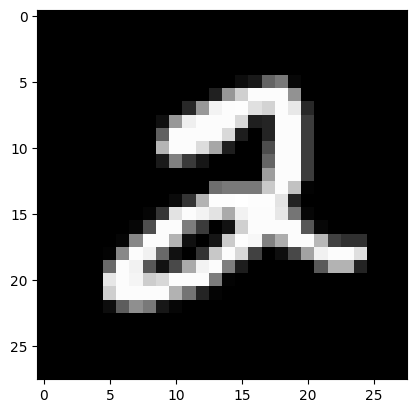

In [69]:
image, label = dataset[5]
print ('image.shape : ',image.shape)
plt.imshow(image.permute(1,2,0),cmap='gray')
print('Label : ',label)

In [70]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset,[train_size, val_size])

In [71]:
len(train_ds), len(val_ds)

(50000, 10000)

In [72]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size,shuffle =True,num_workers = 4, pin_memory=True)

In [73]:
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [74]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

images.shape :  torch.Size([128, 1, 28, 28])


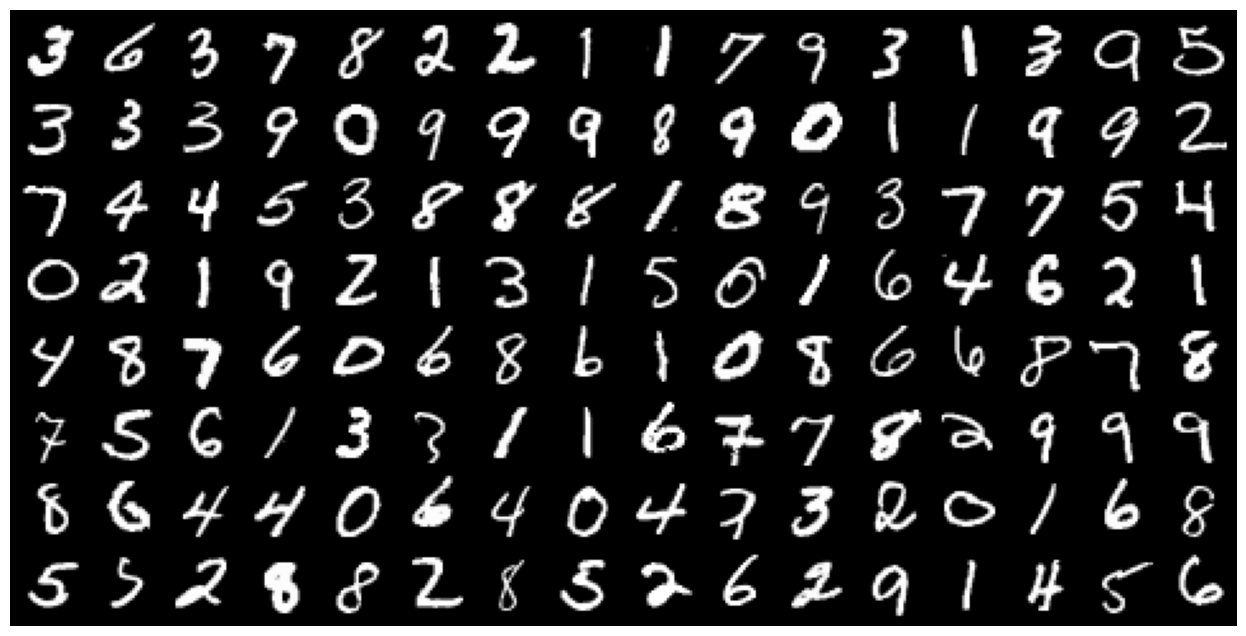

In [75]:
for images,_ in train_loader:
  print('images.shape : ',images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow =16).permute(1,2,0))
  break

In [76]:
for images,labels in train_loader:
  print('images.shape : ',images.shape)
  input = images.reshape(-1,784)
  print('inputs.shape : ',input.shape)
  break

images.shape :  torch.Size([128, 1, 28, 28])
inputs.shape :  torch.Size([128, 784])


In [77]:
input_size = input.shape[-1]
input_size
hidden_size = 32

In [78]:
layer1 = nn.Linear(input_size, hidden_size)

In [79]:
input.shape

torch.Size([128, 784])

In [80]:
layer1_outputs = layer1(input)

In [81]:
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [82]:
# eg :
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [83]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6712065935134888
min(relu_outputs): 0.0


In [84]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [85]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [86]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3258, grad_fn=<NllLossBackward0>)

In [87]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [88]:
class MnistModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size,hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)
  def forward(self, xb):
    xb = xb.view(xb.size(0),-1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,label)
    acc = accuracy(out,labels)
    return {'val_loss': loss, 'val_acc': acc}
  def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [89]:
input_size = 784
hidden_size = 50 # you can change this
num_classes = 10

In [90]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [91]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [93]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs,labels)
  print('loss : ',loss.item())
  break

print('Outputs.shape : ',outputs.shape)
print('Sample output : \n ', outputs[:2].data)

loss :  2.3245325088500977
Outputs.shape :  torch.Size([128, 10])
Sample output : 
  tensor([[-0.0526,  0.0889,  0.1286, -0.0232, -0.2266,  0.0768, -0.1644, -0.1150,
          0.0615, -0.1499],
        [-0.1047,  0.1601,  0.2593,  0.0435, -0.3744,  0.0083, -0.3007, -0.1330,
          0.1368, -0.1030]])


In [97]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

In [95]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [98]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


In [99]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [100]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [101]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [102]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [103]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
)

In [104]:
history = [evaluate(model, val_loader)]
history

AttributeError: 'MnistModel' object has no attribute 'validation_step'

In [106]:
history += fit(5, 0.5, model, train_loader, val_loader)